# Transformer from Scratch on German to English translation

## Introduction

In this notebook I will be running the Transformer built from scratch in the class on German to English translation. 
I will compare the quality of translation using BLEU score. And also compare it with the BLEU score obtained when not using the Transformer.

## Preparing Data

First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Next, we'll set the random seed for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=db90761b113f0cbb827fc4ef9b698240310d0a423232e0c23f7bdc7781d1ed5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-c1vqj5x9/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [4]:
!pip install torchtext

##Preparing the data

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

Define the source and target language and create place holders for tokens and vocabulary


In [6]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

Create source and target language tokenizer.


In [7]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en')

In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [10]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 959kB/s]


In [11]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [12]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Building the Model
### Building the transfomer from scratch 

Here we will be using implementation of Transformer as defined in "Attention is all you need" paper.
1. First thing we need is self attention, which is used in both encoder and decoder blocks. Thus the implementation of self attention is very generic, and with right set of parameters can be used with both Encoder and Decoder.
2. Decoder additionally needs multiheaded attention. So we will build that separately for Decoder.

In [14]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

We define the Transformer block 


In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

Encoder Definition

In [16]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

We define the decoder block, which will be used in Decoder class

In [17]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

Finally we define the transformer


In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE]) #len(SRC.vocab)
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE]) #len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
BATCH_SIZE=128
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [22]:
SRC_PAD_IDX = PAD_IDX # SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = PAD_IDX #TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

## Training the Transfomer
 Model

Next up, initializing the model and placing it on the GPU.

In [23]:
device

device(type='cuda')

In [25]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Then, we initialize the model parameters.

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(19206, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,482,520 trainable parameters


Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [28]:
from torch.utils.data import DataLoader

In [29]:
#optimizer = optim.Adam(model.parameters())

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Next, we'll define our training and evaluation loops.

As we are using `include_lengths = True` for our source field, `batch.src` is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [31]:
######################################################################
# Collation
# ---------
#   
# As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
# We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
# defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
# can be fed directly into our model.   
#


from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch,src_len = [], [],[]
    for src_sample, tgt_sample in batch:
        
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
        
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    src_len.append(len(src_batch))#.shape[0])
    src_len=torch.tensor(src_len*len(src_batch[0]))
    return src_batch, tgt_batch,src_len

In [32]:
def train(model, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    for src,trg,_ in train_dataloader: 
        src=torch.transpose(src, 0,1).to(device) 
        trg=torch.transpose(trg, 0,1).to(device)    
        #src = src.to(device)
        #trg = trg.to(device)
        #trg=trg[:,:-1]
        #src_len = src_len.to(device)
        
              
        optimizer.zero_grad()
        
        output,_ = model(src, trg[:,:-1])
        
        #trg = [batch size, trg len]
        #output = [batch size, trg len, output dim]
        #output = output.reshape(-1, output.shape[2])
        # trg = trg[:,1:].reshape(-1)
       
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
              
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_dataloader)

In [33]:
def evaluate(model, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
        val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
        for src,trg,_ in val_dataloader:    
            src=torch.transpose(src, 0,1).to(device) 
            trg=torch.transpose(trg, 0,1).to(device)
            #src_len = src_len.to(device)
       
            output,_ = model(src, trg[:,:-1]) 
            #output = output.reshape(-1, output.shape[2])
            #trg = trg[:,1:].reshape(-1)
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            #trg = [batch size, trg len]
            #output = [batch size, trg len, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(val_dataloader)

Then, we'll define a useful function for timing how long epochs take.

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The penultimate step is to train our model. 

In [35]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model,  optimizer, criterion, CLIP)
    valid_loss = evaluate(model,  criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 166kB/s]


Epoch: 01 | Time: 0m 26s
	Train Loss: 6.869 | Train PPL: 961.662
	 Val. Loss: 5.156 |  Val. PPL: 173.394
Epoch: 02 | Time: 0m 24s
	Train Loss: 4.470 | Train PPL:  87.330
	 Val. Loss: 4.043 |  Val. PPL:  56.987
Epoch: 03 | Time: 0m 24s
	Train Loss: 3.820 | Train PPL:  45.626
	 Val. Loss: 3.725 |  Val. PPL:  41.476
Epoch: 04 | Time: 0m 24s
	Train Loss: 3.509 | Train PPL:  33.404
	 Val. Loss: 3.519 |  Val. PPL:  33.741
Epoch: 05 | Time: 0m 24s
	Train Loss: 3.275 | Train PPL:  26.443
	 Val. Loss: 3.366 |  Val. PPL:  28.963
Epoch: 06 | Time: 0m 24s
	Train Loss: 3.083 | Train PPL:  21.813
	 Val. Loss: 3.238 |  Val. PPL:  25.484
Epoch: 07 | Time: 0m 24s
	Train Loss: 2.907 | Train PPL:  18.301
	 Val. Loss: 3.140 |  Val. PPL:  23.108
Epoch: 08 | Time: 0m 24s
	Train Loss: 2.754 | Train PPL:  15.711
	 Val. Loss: 3.066 |  Val. PPL:  21.466
Epoch: 09 | Time: 0m 25s
	Train Loss: 2.618 | Train PPL:  13.703
	 Val. Loss: 2.998 |  Val. PPL:  20.046
Epoch: 10 | Time: 0m 24s
	Train Loss: 2.491 | Train PPL

Finally, we load the parameters from our best validation loss and get our results on the test set.

In [36]:
def test_evaluate(model, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
        test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
        for src,trg,_ in test_dataloader:    
            src=torch.transpose(src, 0,1).to(device) 
            trg=torch.transpose(trg, 0,1).to(device)
            #src_len = src_len.to(device)
       
            output,_ = model(src, trg[:,:-1])
            
            #trg = [batch size, trg len]
            #output = [batch size, trg len, output dim]

            #output_dim = output.shape[-1]
            
            #output = output.reshape(-1, output.shape[2])
            #trg = trg[:,1:].reshape(-1)
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(test_dataloader)

In [37]:
model.load_state_dict(torch.load('tut4-model.pt'))

<All keys matched successfully>

In [38]:
test_loss = test_evaluate(model,  criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 158kB/s]


| Test Loss: 2.521 | Test PPL:  12.446 |


In [39]:
def new_translation(sentence,model,device,max_len=50):
  
  src_sample,tgt_sample=sentence
  src=text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
  src=src.unsqueeze(0).to(device)
  #trg=text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n"))
  #src_len=torch.tensor([src.shape[1]])
  #print(src_len)  
  
  trg_indexes=[BOS_IDX]
  src_mask = model.make_src_mask(src)
  with torch.no_grad():
        enc_src = model.encoder(src, src_mask)
  #attentions = torch.zeros(max_len, 1, src.shape[0]).to(device)
  for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device) 
        trg_mask = model.make_trg_mask(trg_tensor)
        #trg_tensor=trg_tensor.unsqueeze(0).to(device)          
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src,trg_mask, src_mask)
        pred_token = output.argmax(2)[:,-1].item() #output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == EOS_IDX :
            break
  trg_tokens=[(vocab_transform["en"].get_itos())[i] for i in trg_indexes]   
  return trg_tokens[1:],attention

In [40]:
from torchtext.data.utils import get_tokenizer
tokenizer=get_tokenizer(None)

In [41]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [42]:
test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

In [43]:
senten=next(test_iter)
senten

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.\n',
 'A man in an orange hat starring at something.\n')

In [44]:
src_sample,tgt_sample=senten
src_sample, tgt_sample

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.\n',
 'A man in an orange hat starring at something.\n')

In [45]:
src=text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
trg=text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n"))
src, trg

(tensor([  2,   6,  13,  11,   7, 179, 109,   9,  17,  79,   0,   5,   3]),
 tensor([   2,    7,   13,    8,   29,   92,   69, 2671,   21,  123,    6,    3]))

In [46]:
translation, attention = new_translation(senten, model, device)

In [47]:
translation

['A',
 'man',
 'in',
 'a',
 'orange',
 'hat',
 'is',
 'using',
 'his',
 'drill',
 '.',
 '<eos>']

In [48]:
sentenc=next(test_iter)

In [49]:
translation, attention = new_translation(sentenc,model, device)
print(f'predicted trg = {translation}')


predicted trg = ['A', 'husky', 'eastern', 'greyhound', 'dogs', 'are', 'running', 'through', 'the', 'grass', '.', '<eos>']


In [58]:
predicted= " ".join(translation)
predicted

'A man in a vest is sitting in a chair holding a spoon . <eos>'

In [50]:
src_sample,tgt_sample=sentenc
src_sample, tgt_sample

('Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.\n',
 'A Boston Terrier is running on lush green grass in front of a white fence.\n')

In [51]:
src=text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
trg=text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n"))
src, trg

(tensor([   2,    6, 3690, 4018,   87,   44,    0,  121,   29,    7,   53,  328,
            5,    3]),
 tensor([   2,    7, 3375, 4933,   11,   83,   10, 2603,   52,  102,    8,   45,
           14,    4,   25,  275,    6,    3]))

In [52]:
src=tokenizer(src_sample)

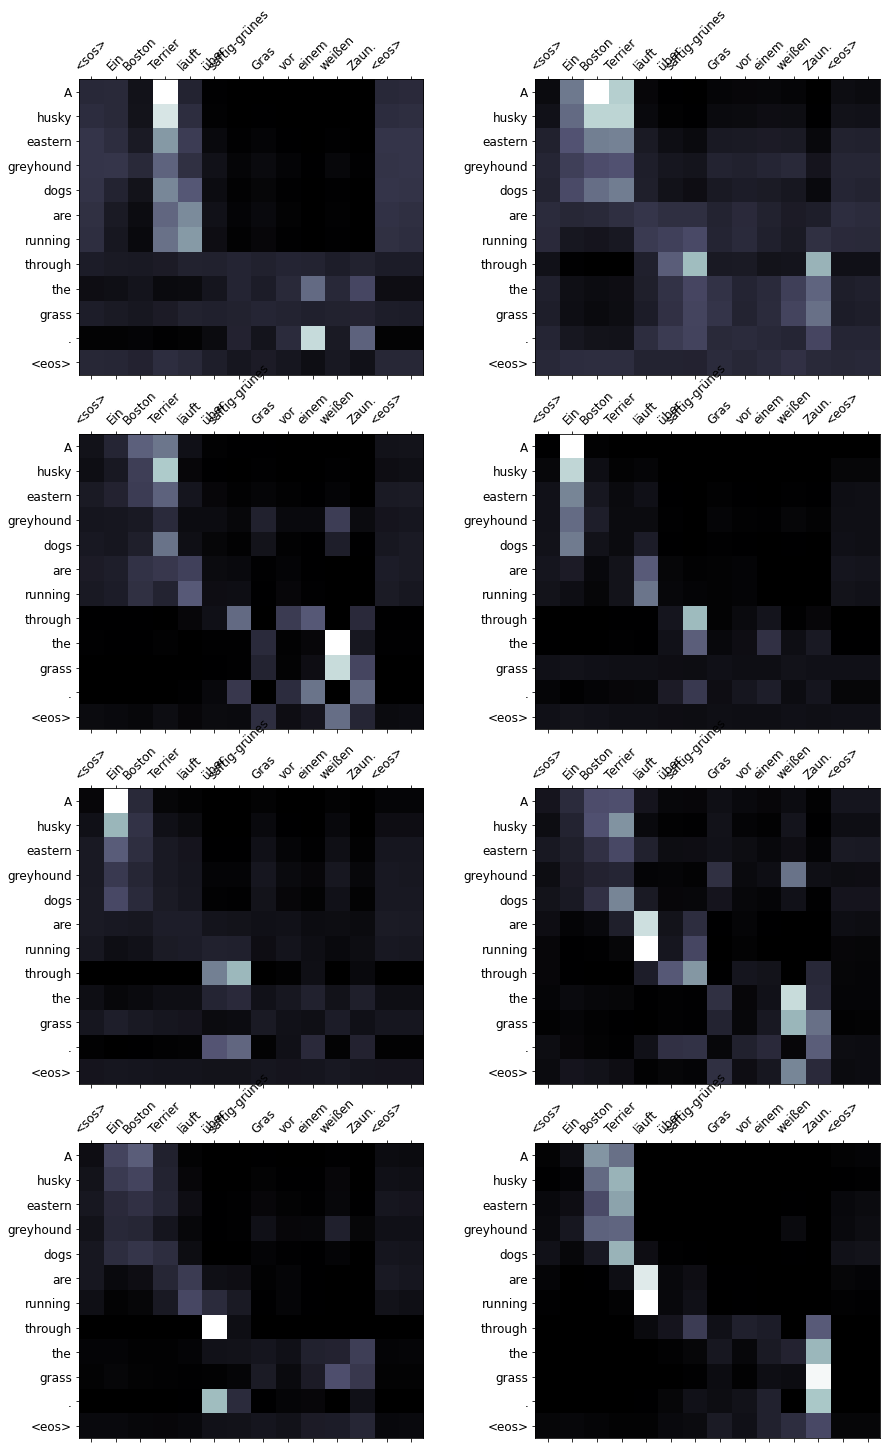

In [53]:
display_attention(src, translation, attention)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [54]:
from torchtext.data.metrics import bleu_score


In [55]:
def new_calculate_bleu(model, device, max_len = 50):
  tkn=spacy.load('en')
  test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  trgs=[]
  predicted_trgs=[]
  for sentence in test_iter:    
      src,trg = sentence
      trg=tokenizer(trg)
      pred_trg,_ = new_translation(sentence, model, device, max_len)
        
      #cut off <eos> token
      pred_trg = pred_trg[:-1]
      predicted_trgs.append(pred_trg)
      trgs.append([trg])
  return bleu_score(predicted_trgs,trgs)


*This is what original authors have mentioned*</br>
We get a BLEU of around 28. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of 26.75. This is similar to our score, however they are using a completely different dataset and their model size is much larger - 1000 hidden dimensions which takes 4 days to train! - so we cannot really compare against that either.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".


In [56]:
bscore = new_calculate_bleu(model, device)

print(f'BLEU score = {bscore*100:.2f}')

BLEU score = 19.18


In [62]:
test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
for i in range(10):
  sentenc=next(test_iter)
  src,trg = sentenc
  translation, attention = new_translation(sentenc,model, device)
  print(f'German = {src}') 
  print(f'English actual = {trg}') 
  predicted_trg=' '.join(translation)
  print(f'English translated = {predicted_trg}') 
  print("\n\n")


German = Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.

English actual = A man in an orange hat starring at something.

English translated = A man in a orange hat is using his drill . <eos>



German = Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.

English actual = A Boston Terrier is running on lush green grass in front of a white fence.

English translated = A husky eastern greyhound dogs are running through the grass . <eos>



German = Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.

English actual = A girl in karate uniform breaking a stick with a front kick.

English translated = A girl in a karate uniform is wearing a helmet and is wearing a stick . <eos>



German = Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.

English actual = Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.

English translated = Five people in differe

In the next tutorials we will be moving away from using recurrent neural networks and start looking at other ways to construct sequence-to-sequence models. Specifically, in the next tutorial we will be using convolutional neural networks.